In [1]:
import json
import gcsfs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client, LocalCluster
import dask
import zarr
from dask.diagnostics import ProgressBar

from utils import smooth_inputs
from cm26_utils import load_and_combine_cm26

# set up gcs filesystem
# 👇 replace with your key 
with open( '/home/jovyan/KEYS/pangeo-forge-ocean-transport-4967-347e2048c5a1.json') as token_file:
    token = json.load(token_file)
fs = gcsfs.GCSFileSystem(token=token)

In [2]:
flux_path = 'ocean-transport-group/scale-aware-air-sea/flux-output/cm26_split_full_v2.zarr'
flux_mapper = fs.get_mapper(flux_path)
ds_flux = xr.open_dataset(
    flux_mapper,
    engine='zarr',
    chunks={},
    consolidated=True,
    inline_array=True
)
ds_flux

,Array,Chunk
Bytes,5.17 TiB,111.24 MiB
Shape,"(5, 4, 7305, 2700, 3600)","(1, 1, 3, 2700, 3600)"
Count,1 Graph Layer,48700 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,5.17 TiB,111.24 MiB
Shape,"(5, 4, 7305, 2700, 3600)","(1, 1, 3, 2700, 3600)"
Count,1 Graph Layer,48700 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [3]:
ds_flux.nbytes/1e12

28.401840109208

In [4]:
from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
        cluster = gateway.connect(c.name)
        cluster.shutdown()  

options = gateway.cluster_options()

options.worker_memory = 32 # 24 works fine for long term mean, but seasonal needs a bit more
options.worker_cores = 8

options.environment = dict(
    DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
)

# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()
cluster.adapt(4, 100)
client

[ClusterReport<name=prod.ed527f6a506f41299369ec4f87613c40, status=RUNNING>]


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.666ef199161f46dd80dcafdbe2b86e0c/status,


In [5]:
def split_loading(ds, split_dim='smoothing'):
    ds_loaded = xr.Dataset()
    for var in ds.data_vars:
        # TODO: How can I index over more than one split dimension? 
        # E.g. I want to load only a single algo/smoothing, compute 
        # that and then merge the results back into the same dataset structure
        # Test for this would be to not load at all and see if the dataset is
        # the same before and after
        datasets = []
        for split_item in ds[split_dim]:
            print(f"Loading {var} for {split_dim}={split_item.data}")
            datasets.append(ds[var].sel({split_dim:split_item}).load())
        ds_loaded[var] = xr.concat(datasets, dim=split_dim)
    return ds_loaded

### Long term mean

In [14]:
results_long_term_path = 'ocean-transport-group/scale-aware-air-sea/results/cm26_flux_long_term_mean_v2.zarr'
results_long_term_mapper = fs.get_mapper(results_long_term_path)

In [14]:
# long term mean
# getting this all in one .to_zarr operation causes a bunch of crashes... annoying...
ds_flux_mean = split_loading(ds_flux.mean('time')).chunk({'algo':1,'smoothing':1})
# I guess this could just be persist?
ds_flux_mean.to_zarr(results_long_term_mapper, mode='w', consolidated=True)

Loading evap for smoothing=smooth_full
Loading evap for smoothing=smooth_tracer
Loading evap for smoothing=smooth_vel
Loading evap for smoothing=smooth_all
Loading qh for smoothing=smooth_full
Loading qh for smoothing=smooth_tracer
Loading qh for smoothing=smooth_vel
Loading qh for smoothing=smooth_all
Loading ql for smoothing=smooth_full
Loading ql for smoothing=smooth_tracer
Loading ql for smoothing=smooth_vel
Loading ql for smoothing=smooth_all
Loading taux for smoothing=smooth_full
Loading taux for smoothing=smooth_tracer
Loading taux for smoothing=smooth_vel
Loading taux for smoothing=smooth_all
Loading tauy for smoothing=smooth_full
Loading tauy for smoothing=smooth_tracer
Loading tauy for smoothing=smooth_vel
Loading tauy for smoothing=smooth_all


### Seasonal mean

In [6]:
results_seasonal_path = 'ocean-transport-group/scale-aware-air-sea/results/cm26_flux_seasonal_mean_v2.zarr'
results_seasonal_mapper = fs.get_mapper(results_seasonal_path)

In [7]:
# seasonal mean
# TODO: Something is not working properly with the stresses for this one...
ds_flux_seasonal = split_loading(ds_flux[['ql', 'qh', 'evap']].groupby('time.season').mean('time')).chunk({'algo':1,'smoothing':1})
ds_flux_seasonal.to_zarr(results_seasonal_mapper, mode='w', consolidated=True)

Loading ql for smoothing=smooth_full
Loading ql for smoothing=smooth_tracer
Loading ql for smoothing=smooth_vel
Loading ql for smoothing=smooth_all
Loading qh for smoothing=smooth_full
Loading qh for smoothing=smooth_tracer
Loading qh for smoothing=smooth_vel
Loading qh for smoothing=smooth_all
Loading evap for smoothing=smooth_full
Loading evap for smoothing=smooth_tracer
Loading evap for smoothing=smooth_vel
Loading evap for smoothing=smooth_all


NameError: name 'results_long_term_mapper' is not defined

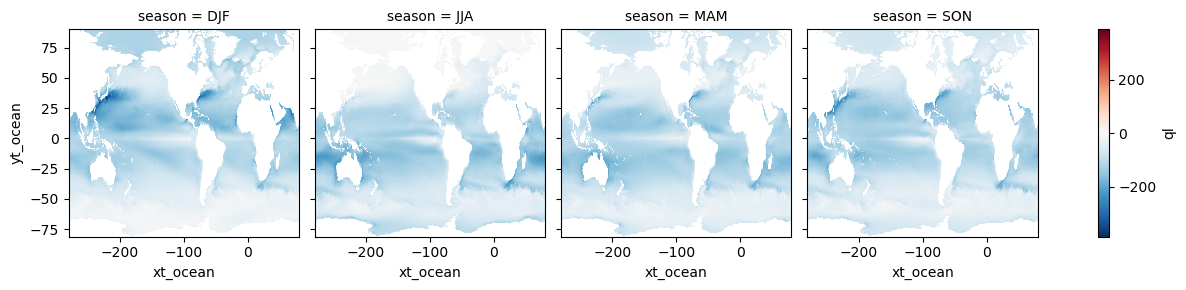

In [11]:
ds_flux_seasonal['ql'].isel(smoothing=0, algo=0).plot(col='season')

In [12]:
ds_flux_seasonal.to_zarr(results_seasonal_mapper, mode='w', consolidated=True)

## Check results

In [ ]:
mean_reloaded = xr.open_dataset(results_long_term_mapper, engine='zarr')
for var in mean_reloaded.data_vars:
    plt.figure()
    mean_reloaded[var].plot(col='smoothing', row='algo')

In [ ]:
seasonal_reloaded = xr.open_dataset(results_seasonal_mapper, engine='zarr')
for var in mean_reloaded.data_vars:
    for season in seasonal_reloaded.season
        plt.figure()
        seasonal_reloaded[var].sel(season=season).plot(col='smoothing', row='algo').plot()